In [1]:
# import libraries
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

In [2]:
# load labels and features
# Note: the labels are located in the last column of the last sheet in the excel file
# Note: the features are located in the first n_features columns of each sheet in the excel file
# This case is the first 26 columns 
n_features = 26
scalar = StandardScaler()
x_file_name = 'data/Numeric_data_for_cells_COMBINED.xls'
x_data_xls = pd.ExcelFile(x_file_name)
data_df = pd.read_excel(x_data_xls, x_data_xls.sheet_names[-1], header=None)
y_time = np.array(data_df.iloc[:,-1])
y_array = y_time-1
X_array = scalar.fit_transform(data_df.iloc[:,:n_features].to_numpy())

In [3]:
# Prepare train/test data
train_x, test_x, train_y, test_y = train_test_split(X_array, y_array, test_size=0.3, random_state=42)
train_x = torch.Tensor(train_x).to(torch.float32)
test_x = torch.Tensor(test_x).to(torch.float32)
train_y = torch.Tensor(train_y).long()
test_y = torch.Tensor(test_y).long()

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

In [24]:
class MLPModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_size=8):
        super(MLPModel, self).__init__()
        self.numerical_features_ = nn.Sequential(
            nn.Linear(input_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, output_features),
        )
    def forward(self, numerical_features):
        out = self.numerical_features_(numerical_features)
        return out

In [25]:
# Calculate Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

# Training loop function
def training_loop(model, optimizer, loss_fn, epochs, train_dataloader, test_dataloader):
    # Value tracking
    epoch_count = []
    loss_values = []
    acc_values = []
    test_loss_values = []
    test_acc_values = []

    for epoch in tqdm(range(epochs)):
        model.train()
        for batch, (x, y) in enumerate(train_dataloader):
            x, y = x.to(device), y.to(device)
            # Forward pass
            y_logits = model(x)
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            # Calculate loss/accuracy
            loss = loss_fn(y_logits, y)
            acc = accuracy_fn(y, y_pred)
            # Optimizer zero grad
            optimizer.zero_grad()
            # Loss backward
            loss.backward()
            # Optimizer step
            optimizer.step()

        # Testing
        model.eval()
        with torch.inference_mode():
            test_loss, correct = 0, 0
            for x, y in test_dataloader:
                x, y = x.to(device), y.to(device)
                test_logits = model(x)
                test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
                test_loss += loss_fn(test_logits, y).item()
                correct += (test_pred == y).type(torch.float).sum().item()
            # Calculate test loss
            test_loss = test_loss / len(test_dataloader)
            test_acc = correct / len(test_dataloader.dataset)
        if epoch % 2 == 0:
            epoch_count.append(epoch)
            loss_values.append(loss.to(device).item())
            acc_values.append(acc / 100.0)
            test_loss_values.append(test_loss)
            test_acc_values.append(test_acc)

    return epoch_count, loss_values, acc_values, test_loss_values, test_acc_values

# Prediction function
def predict(model, x, y):
    model.eval()
    with torch.no_grad():
        y_logits = model(x)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        acc = accuracy_fn(y, y_pred)
        mat = confusion_matrix(y, y_pred)
    return {"accuracy":acc, "matrix": mat, "prediction": y_pred.to(device).numpy()}

In [56]:
# Define model and training parameters
torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

# number of features
IN_FEATURES = n_features
# number of classes
NUM_CLASSES = 3
# number of features in hidden state
HIDDEN_SIZE = 128
# learning rate
LEARNING_RATE = 1e-4
# number of samples per batch
BATCH_SIZE = 64
# number of epochs to train
epochs = 40

# Initialize model, loss function and optimizer
model = MLPModel(IN_FEATURES, NUM_CLASSES, hidden_size=HIDDEN_SIZE).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# load datasets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# Train model
epoch_count, loss_values, acc_values, test_loss_values, test_acc_values = training_loop(model, optimizer, loss_fn, epochs, train_dataloader, test_dataloader)

100%|██████████| 40/40 [00:01<00:00, 32.06it/s]


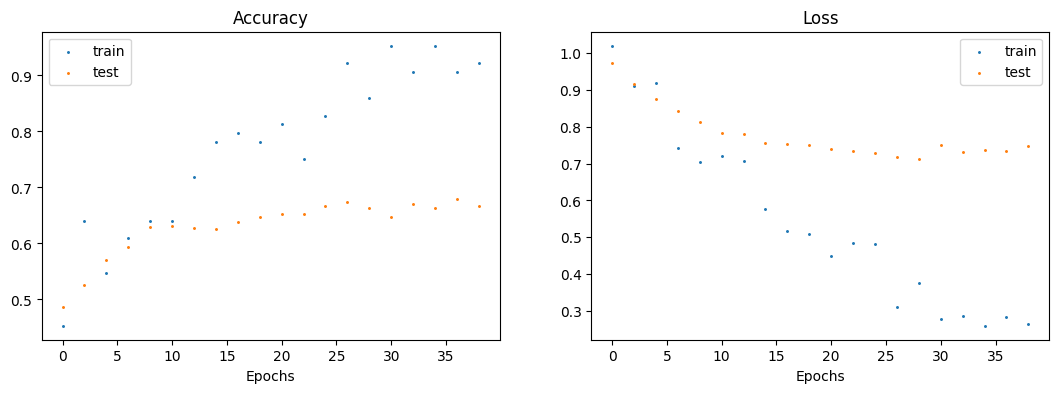

In [57]:
# Plot model training results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

ax1.set_title("Accuracy")
ax1.scatter(epoch_count, acc_values, label="train", marker=".", s=5)
ax1.scatter(epoch_count, test_acc_values, label="test", marker=".", s=5)
ax1.set_xlabel('Epochs')
ax1.legend()

ax2.set_title("Loss")
ax2.scatter(epoch_count, loss_values, label="train", marker=".", s=5)
ax2.scatter(epoch_count, test_loss_values, label="test", marker=".", s=5)
ax2.set_xlabel('Epochs')
ax2.legend()

plt.show()

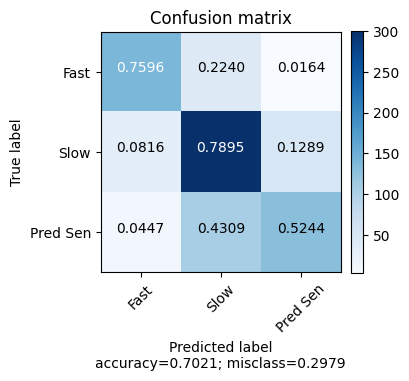

In [58]:
# Plot confusion matrix function
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# predict from the trained model
pred_dict = predict(model, test_x, test_y)
# plot confusion matrix
plot_confusion_matrix(pred_dict['matrix'], ['Fast', 'Slow', 'Pred Sen'], normalize=True)